# Multi-layer perceptron

In [1]:
## If problems arise with the loading of the shared library, this script can be used to load the shared library before other libraries.
## Remember to also run on your local machine the script below:
# bash replace_lib_version.sh

import platform
import ctypes

# if platform.system() == "Linux":
#     # Force libgomp to be loaded before other libraries consuming dynamic TLS (to avoid running out of STATIC_TLS)
#     ctypes.cdll.LoadLibrary("libgomp.so.1")
#     ctypes.cdll.LoadLibrary(
#         "/home/vscode/.local/lib/python3.12/site-packages/py_nillion_client/py_nillion_client.abi3.so"
#     )

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
print(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import json
import nada_numpy as na
import numpy as np
import py_nillion_client as nillion
import torch
from common.utils import store_program, store_secrets
from cosmpy.aerial.client import LedgerClient
from cosmpy.aerial.wallet import LocalWallet
from cosmpy.crypto.keypairs import PrivateKey
from dotenv import load_dotenv
from nada_ai.client import TorchClient
from nillion_python_helpers import (create_nillion_client,
                                    create_payments_config)
from py_nillion_client import NodeKey, UserKey

from torch import nn
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

home = os.getenv("HOME")
load_dotenv(f"{home}/.config/nillion/nillion-devnet.env")
print((f"{home}/.config/nillion/nillion-devnet.env"))

/home/brglt/Desktop/nillion/quickstart


/home/brglt/.config/nillion/nillion-devnet.env


### Train a Covid image classification model on CT scans

Before this step you must install kaggle

In [3]:
# !kaggle datasets download mehradaria/covid19-lung-ct-scans -p data --unzip

In [4]:
class MelanomaDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: os.PathLike, transform) -> None:
        self.root_dir = root_dir
        self.transform = transform

        self.classes = ["Benign", "Malignant"]

        self.data = []
        self.targets = []

        for class_index, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(class_dir, filename)
                    self.data.append(img_path)
                    self.targets.append(class_index)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index]
        label = self.targets[index]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label

In [5]:
# Create custom torch Module
class MyNN(nn.Module):
    """My brand new model"""

    def __init__(self) -> None:
        """Model is a two layers and an activations"""
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=2, kernel_size=3, padding=1, stride=3
        )
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=18, out_features=2)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x: na.NadaArray) -> na.NadaArray:
        """My forward pass logic"""
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

my_model = MyNN()

In [6]:
dataset = MelanomaDataset(
    os.path.join("src/data", "train"),
    
    transform=transforms.Compose(
        [
            transforms.Grayscale(),
            transforms.Resize((16, 16)),
            transforms.ToTensor(),
        ]
    ),
)
trainset, testset = torch.utils.data.random_split(dataset, [0.8, 0.2])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(my_model.parameters(), lr=1e-4)

In [7]:
accuracies, losses = [], []
for epoch in range(1):
    print(f"Starting epoch {epoch+1}...")

    incorrect, correct = 0, 0
    current_loss = 0
    for i, data in enumerate(trainloader):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = my_model(inputs)
        loss = loss_function(outputs, targets)

        preds = torch.argmax(outputs, axis=1)

        correct += (preds == targets).float().sum()
        incorrect += (preds != targets).float().sum()

        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        if i % 100 == 99:
            accuracy = 100 * correct / (incorrect + correct)
            accuracies.append(accuracy)

            print("Loss after mini-batch %5d: %.3f" % (i + 1, current_loss / 100))
            losses.append(current_loss / 100)
            print("Accuracy after mini-batch %5d: %.3f" % (i + 1, accuracy))

            correct, incorrect = 0, 0
            current_loss = 0

Starting epoch 1...


/home/brglt/miniconda3/envs/ml/lib/python3.12/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380481/work/c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss after mini-batch   100: 0.703
Accuracy after mini-batch   100: 41.812
Loss after mini-batch   200: 0.699
Accuracy after mini-batch   200: 47.625
Loss after mini-batch   300: 0.693
Accuracy after mini-batch   300: 56.500
Loss after mini-batch   400: 0.691
Accuracy after mini-batch   400: 53.625
Loss after mini-batch   500: 0.686
Accuracy after mini-batch   500: 55.875


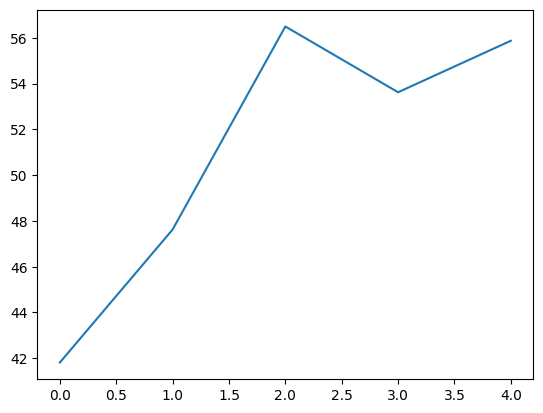

In [8]:
plt.plot(accuracies)

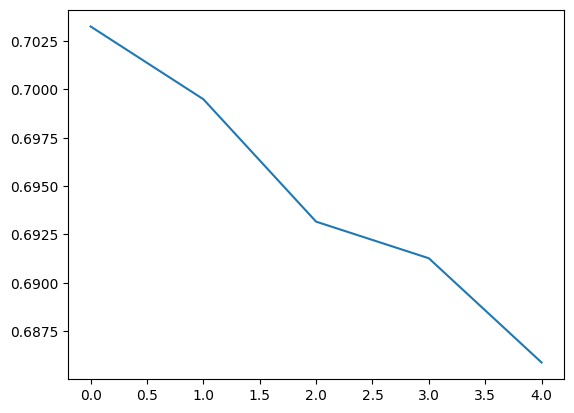

In [9]:
plt.plot(losses)

In [10]:
y_pred = []
y_true = []
for i, data in enumerate(testloader):
    inputs, targets = data

    outputs = my_model(inputs)
    preds = torch.argmax(outputs, axis=1)

    y_pred.extend(preds.tolist())
    y_true.extend(targets.tolist())

In [11]:
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("precision: {:.3f}%".format(precision[1] * 100))
print("recall: {:.3f}%".format(recall[1] * 100))
print("f1: {:.3f}%".format(f1[1] * 100))
print("support: {}".format(support[1]))

precision: 0.000%
recall: 0.000%
f1: 0.000%
support: 1134


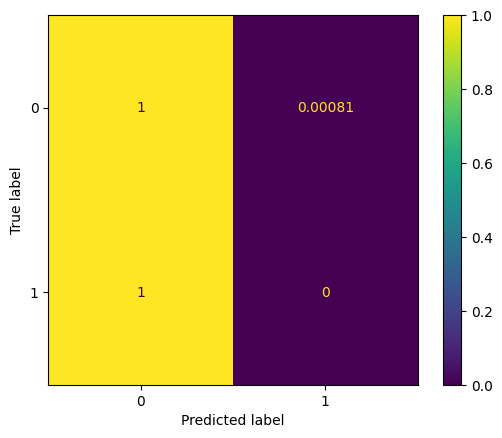

In [12]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, normalize="true"), )
disp.plot()

## Model Provider flow

### Authenticate with Nillion

To connect to the Nillion network, we need to have a user key and a node key. These serve different purposes:

The `user_key` is the user's private key. The user key should never be shared publicly, as it unlocks access and permissions to secrets stored on the network.

The `node_key` is the node's private key which is run locally to connect to the network.

In [13]:
os.getcwd()

'/home/brglt/Desktop/nillion/quickstart/nada_quickstart_programs'

In [14]:
# Load all Nillion network environment variables
os.getcwd()
assert os.getcwd().endswith(
    "nada_quickstart_programs"
), "Please run this script from the examples/multi_layer_perceptron directory otherwise, the rest of the tutorial may not work"
load_dotenv()
print(os.getenv("NILLION_CLUSTER_ID"))
dotenv_path = '/home/brglt/Desktop/nillion/quickstart/nada_quickstart_programs/.env'
load_dotenv(dotenv_path)
print(os.getenv("NILLION_CLUSTER_ID"))

9e68173f-9c23-4acc-ba81-4f079b639964
9e68173f-9c23-4acc-ba81-4f079b639964


In [15]:
print(os.getenv("NILLION_CLUSTER_ID"))

9e68173f-9c23-4acc-ba81-4f079b639964


In [16]:
cluster_id = os.getenv("NILLION_CLUSTER_ID")
grpc_endpoint = os.getenv("NILLION_NILCHAIN_GRPC")
chain_id = os.getenv("NILLION_NILCHAIN_CHAIN_ID")
seed = "my_seed"
model_provider_userkey = UserKey.from_seed((seed))
model_provider_nodekey = NodeKey.from_seed((seed))
model_provider_client = create_nillion_client(model_provider_userkey, model_provider_nodekey)
model_provider_party_id = model_provider_client.party_id
model_provider_user_id = model_provider_client.user_id

In [17]:
env_vars = {key: os.getenv(key) for key in os.environ.keys()}

# Print the environment variables
for key, value in env_vars.items():
    print(f'{key}: {value}')

CHROME_DESKTOP: code-url-handler.desktop
CONDA_DEFAULT_ENV: ml
CONDA_EXE: /home/brglt/miniconda3/bin/conda
CONDA_PREFIX: /home/brglt/miniconda3/envs/ml
CONDA_PROMPT_MODIFIER: (ml) 
CONDA_PYTHON_EXE: /home/brglt/miniconda3/bin/python
CONDA_SHLVL: 2
DBUS_SESSION_BUS_ADDRESS: unix:path=/run/user/1000/bus
DEBUGINFOD_URLS: https://debuginfod.ubuntu.com 
DESKTOP_SESSION: ubuntu-wayland
DISPLAY: :0
GDK_BACKEND: x11
GDMSESSION: ubuntu-wayland
GIO_LAUNCHED_DESKTOP_FILE: /usr/share/applications/code.desktop
GIO_LAUNCHED_DESKTOP_FILE_PID: 3742
GJS_DEBUG_OUTPUT: stderr
GJS_DEBUG_TOPICS: JS ERROR;JS LOG
GNOME_DESKTOP_SESSION_ID: this-is-deprecated
GNOME_SETUP_DISPLAY: :1
GNOME_SHELL_SESSION_MODE: ubuntu
GTK_MODULES: gail:atk-bridge
HOME: /home/brglt
IM_CONFIG_CHECK_ENV: 1
IM_CONFIG_PHASE: 1
INVOCATION_ID: 3dd17922280d4ab9b26a973d8e131735
JOURNAL_STREAM: 8:44134
LANG: en_US.UTF-8
LC_ADDRESS: nl_NL.UTF-8
LC_IDENTIFICATION: nl_NL.UTF-8
LC_MEASUREMENT: nl_NL.UTF-8
LC_MONETARY: nl_NL.UTF-8
LC_NAME: nl_N

In [18]:
cluster_id, grpc_endpoint, chain_id, model_provider_party_id

('9e68173f-9c23-4acc-ba81-4f079b639964',
 'localhost:26649',
 'nillion-chain-devnet',
 '12D3KooWJHrXiK2JTCjJxwCCktJPSYsUsz2WHEBSB5iZtqGiZ8Qm')

In [19]:
cluster_id, grpc_endpoint, chain_id, model_provider_party_id

('9e68173f-9c23-4acc-ba81-4f079b639964',
 'localhost:26649',
 'nillion-chain-devnet',
 '12D3KooWJHrXiK2JTCjJxwCCktJPSYsUsz2WHEBSB5iZtqGiZ8Qm')

In [20]:
model_provider_party_id

'12D3KooWJHrXiK2JTCjJxwCCktJPSYsUsz2WHEBSB5iZtqGiZ8Qm'

In [21]:
!pynadac src/multy_percep.py

In [22]:
party_names = ["Provider", "User"]
program_name = "multy_percep"
program_mir_path = f"target/{program_name}.nada.bin"

In [23]:
os.getenv("NILLION_NILCHAIN_PRIVATE_KEY_0")
"ed2978a79df1781fabc55ec395297d2ab0337b1e1d5346f99a9a108bea4c0dc"

'ed2978a79df1781fabc55ec395297d2ab0337b1e1d5346f99a9a108bea4c0dc'

In [24]:
payments_config = create_payments_config(chain_id, grpc_endpoint)
payments_client = LedgerClient(payments_config)
payments_wallet = LocalWallet(
    PrivateKey(bytes.fromhex(os.getenv("NILLION_NILCHAIN_PRIVATE_KEY_0"))),
    prefix="nillion",
)

In [25]:

# Hardcoded private key value
private_key_hex = "ced2978a79df1781fabc55ec395297d2ab0337b1e1d5346f99a9a108bea4c0dc"

# Create the wallet using the hardcoded private key
payments_wallet = LocalWallet(
    PrivateKey(bytes.fromhex(private_key_hex)),
    prefix="nillion",
)


### Upload Nada program to Nillion

TODO: explain what the Nada program does

In [26]:
print(program_mir_path)

target/multy_percep.nada.bin


In [27]:
program_id = await store_program(
    model_provider_client,
    payments_wallet,
    payments_client,
    model_provider_user_id,
    cluster_id,
    program_name,
    program_mir_path,
)

Getting quote for operation...


RuntimeError: requesting price quote: price quote query failed: key not found: ClusterDescriptor_9e68173f-9c23-4acc-ba81-4f079b639964

### Upload weights to Nillion network

In [ ]:
# Create and store model secrets via ModelClient
model_client = TorchClient(my_model)

In [ ]:
model_secrets = nillion.NadaValues(
    model_client.export_state_as_secrets("my_nn", na.SecretRational)
)
permissions = nillion.Permissions.default_for_user(model_provider_client.user_id)
permissions.add_compute_permissions({model_provider_client.user_id: {program_id}})

model_store_id = await store_secrets(
    model_provider_client,
    payments_wallet,
    payments_client,
    cluster_id,
    model_secrets,
    1,
    permissions,
)

Getting quote for operation...
Quote cost is 5570 unil
Submitting payment receipt 5570 unil, tx hash 72E35DB17E9E292124B555661C1F4DA5D7AD9697F77C5FC97B326D42ED5CE698


In [ ]:
os.getcwd()

'/home/brglt/Desktop/nillion/quickstart/nada_quickstart_programs'

In [ ]:
# This information is needed by the model user
with open("src/data/tmp.json", "w") as provider_variables_file:
    provider_variables = {
        "program_id": program_id,
        "model_store_id": model_store_id,
        "model_provider_party_id": model_provider_party_id,
    }
    json.dump(provider_variables, provider_variables_file)

In [ ]:
torch.save(my_model.state_dict(), "src/data/my_model.pt")